# Notebook to generate input for OrnithoScope

In [167]:
import os, os.path
import pandas as pd
from xml.etree import ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

## Format des données en input
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

TODO:

Pour chaque objet : 

- Récupérer filename : bird/task_05-01-2021/2021-01-05-15-56-59.jpg
    L'ajouter au path global

- Récupérer le label

- Récupérer les box

In [ ]:
# Variables
path = '/home/acarlier/OrnithoMate/p0133_bird_data/annotations/'
raw_data_path = '/home/acarlier/OrnithoMate/p0133_bird_data/raw_data/'
tasks_dir = sorted(os.listdir(path))
unwanted_list = ['unknown', 'human', 'noBird']
columns = ["split_value", "file_path","label","x_min", "y_min", "empty_1","empty_2","x_max","y_max","empty_3"]
df_input = pd.DataFrame(columns = columns)
list_object = []

In [242]:
def get_info_from_one_xml(xml_path,list_object):
    i = 0
    tree = ET.parse(xml_path)
    root = tree.getroot()
    #Filename Extraction and local path creation
    filename = root.find("./filename").text
    local_img_path = f"{raw_data_path}{filename.split('/',1)[1]}"
    #Width and height extraction
    width = int(root.find("./size/width").text)
    height = int(root.find("./size/height").text)
    
    for object in root.findall("./object"):
        #Extract specie name
        for attributes in object.findall("./attributes/"):
            if attributes.find('name').text == 'species':
                specie = attributes.find('value').text
        #Data creation
        data = {}
        data['split_value'] = 'TRAINING'
        data['file_path']=local_img_path
        data['label'] = specie
        #Extract bndbx
        bndbox = object.find('./bndbox')
        x_min = round(float(bndbox.find("xmin").text)/width,4)
        y_min = round(float(bndbox.find("ymin").text)/height,4)
        x_max = round(float(bndbox.find("xmax").text)/width,4)
        y_max = round(float(bndbox.find("ymax").text)/height,4)
        #print(xmin, xmax, ymin, ymax)
        data['x_min'] = x_min
        data['y_min'] = y_min
        data["empty_1"] = ""
        data["empty_2"] = ""
        data['x_max'] = x_max
        data['y_max'] = y_max
        data["empty_3"] = ""
        list_object.append(data)
    print(list_object)
    return list_object, local_img_path

#path_test = path+'task_05-01-2021/Annotations/bird/task_05-01-2021/2021-01-05-15-58-14.xml'        
#a, fn = get_info_from_one_xml(path_test,list_object)

In [243]:
def get_info_from_all_xml(tasks_dir,list_object):
    for i in range(len(tasks_dir)):
    # Pour chaque tâche
        task_name = tasks_dir[i]
        #print(task_name)
        complete_path = path + task_name + '/Annotations/bird/' + task_name + '/'
        # Lister toutes les images de la tâche
        image_paths = sorted(os.listdir(complete_path))
        print(image_paths)
        for img in range(len(image_paths)):
            nb_obj, birds = get_info_from_xml(complete_path + image_paths[img],list_object)
        return list_object
    
input = get_info_from_all_xml(tasks_dir,list_object)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [244]:
def create_input_model(list_of_object):
    count = 0
    list_df = []
    for object in list_of_object:
        count +=1
        content = pd.DataFrame(object,index=[count])
        list_df.append(content)
    _ = pd.concat(list_df)
    return _
_ = create_input_model(input)

In [252]:
for label in unwanted_list:
    _ = _[(_.label != label)]

In [259]:
len(_['split_value'])

2438

In [263]:
_.to_csv('test', encoding='utf-8', index=False, header=False) 

/home/acarlier/OrnithoMate/p0133_bird_data/raw_data/task_05-01-2021/2021-01-05-15-58-14.jpg


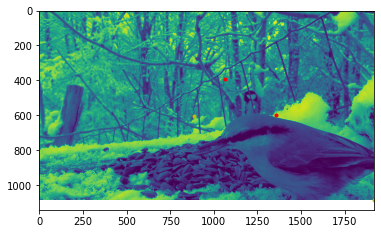

In [268]:
img = cv2.imread(fn, 0) 
print(fn)
plt.imshow(img)
plt.plot(0.5558*1920, 0.3581*1088, 'r.' )
plt.plot(0.7055*1920, 0.5479*1088, 'r.' )
plt.plot(0.4613*1920, 0.555*1088, 'y.' )
plt.plot(0.999*1920, 1.0*1088, 'y.' )
plt.show()

In [ ]:
'''
path = '/home/acarlier/OrnithoMate/p0133_bird_data/annotations/'
tasks_dir = sorted(os.listdir(path))

unwanted_list = ['unknown', 'human', 'noBird']

def get_info_from_xml(xml_path):
    mydoc = minidom.parse(xml_path)
    items = mydoc.getElementsByTagName('object')
    nb_obj = len(items)
    nb_obj_real = 0
    birds = []
    for k in range(nb_obj):
        bird = items[k].childNodes[7].childNodes[1].childNodes[3].childNodes[0].data
        if bird not in unwanted_list:
            birds.append(bird)
            nb_obj_real += 1
        if bird == '1L':
            print(xml_path)
            
    return nb_obj_real, birds


total_img = 0
total_obj = 0
total_obj_dict = {}
for i in range(len(tasks_dir)):
    # Pour chaque tâche
    task_name = tasks_dir[i]
    
    task_dict = {}
    
    complete_path = path + task_name + '/Annotations/bird/' + task_name + '/'
    # Lister toutes les images de la tâche
    image_paths = sorted(os.listdir(complete_path))

    nb_img_real = 0
    nb_obj_real = 0
    for img in range(len(image_paths)):
        nb_obj, birds = get_info_from_xml(complete_path + image_paths[img])
        
        if nb_obj > 0:
            nb_img_real += 1
            nb_obj_real += len(birds)
            
            for b in birds:
                if b in task_dict:
                    task_dict[b] += 1
                else:
                    task_dict[b] = 1
                    
                if b in total_obj_dict:
                    total_obj_dict[b] += 1
                else:
                    total_obj_dict[b] = 1
    
    total_img += nb_img_real
    total_obj += nb_obj_real        
    #print(task_name, len(image_paths), nb_img_real, nb_obj_real, task_dict)
    df = df.append({'task_name': task_name, 'img_number':len(image_paths),
                   'usable_img':nb_img_real,'obj_detected_number':nb_obj_real,'detected_ojects_number':task_dict},ignore_index=True)
print('Total images ', total_img, total_obj, total_obj_dict)

'''